# Cohort analysis with Pandas and Seaborn

## Introduction

The objective of this notebook is to show, step by step, how to implement a cohort analysis with Pandas and Seaborn. In this post, my main objective is to present the code -- if you are curious about cohort analysis, there are plenty of articles available online. 

Coming from an R background, I like working with pipes and to chain commands to modify a DataFrame. I had the idea of writing this article when I was trying to implement this type of analysis with Python to understand the Olist data published in Kaggle and struggled with the existing tutorials.

## Cohort analysis

- What is cohort analysis

Cohort analysis is a type of analysis that follows a group of customers over time. For example, instead of analyzing our customers individually, we group them by date of sign-up in our app. In this way, we can analyze whether a marketing campaing implemented in a given month was effective or not.


- Why it matters

Cohort analyses matter because churn is one of the main problems faced by companies nowadays, and every information that can lead to less churning is a valuable business information.

## Olist data

To show how to implement a cohort analysis with `Pandas` and `Seaborn`, I will work with the Olist dataset. It is available on [kaggle](https://www.kaggle.com/olistbr/brazilian-ecommerce) and provide a good example of an e-commerce dataset. The schema of the data is available in the link above.

The Olist plataform connects small business owners (the sellers) with customers from all over Brazil. Understanding whether sellers come back to the platform after their first sale is a crucial business question for Olist. 

Therefore, I will make the cohorts based on the month of the first sale of each seller. With this cohorts, I will track the proportion of sellers from each cohort that came back to the platform in the subsequent months. 

Hence, we must connect the `olist_sellers_dataset` where the `id` of each seller is located with the `olist_orders` dataset where we can find the date of each sale (`order_purchase_timestamp`) in the platform. These two tables are connected through the `olist_order_items_dataset`.

### 1. Import the required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from janitor import clean_names

### 2. Load the data

In [2]:
df_orders = pd.read_csv('Datasets/olist_orders_dataset.csv')
df_order_items = pd.read_csv('Datasets/olist_order_items_dataset.csv')
df_sellers = pd.read_csv('Datasets/olist_sellers_dataset.csv')

Join the datasets, convert `date` to correct type, and select relevant columns:

In [3]:
df = pd.merge(df_order_items, df_orders, on='order_id')
df = pd.merge(df, df_sellers, on='seller_id')
df = (df
     .assign(date = lambda x: pd.to_datetime(x.order_purchase_timestamp))
     .query('date >= "2017-01-01" & date < "2018-09-01"') # Only data from 2017 onwards and before 2018-09
     .loc[:, ['seller_id', 'date']] # Select relevant columns
     )
df.head(3)

,seller_id,date
0,48436dade18ac8b2bce089ec2a041202,2017-09-13 08:59:02
1,48436dade18ac8b2bce089ec2a041202,2017-07-23 16:13:37
2,48436dade18ac8b2bce089ec2a041202,2017-08-10 12:17:35


To find the cohorts, we must find the first appearance (`order_purchase_timestamp`) of each individual seller (`seller_id`). To do that, I'll order the dataset by date of sale and drop the duplicates in the `seller_id` column.


In [4]:
seller_cohort = (df[['seller_id', 'date']]
                 .assign(cohort = lambda x: x.date.dt.to_period('M'))
                 .sort_values('date')
                 .drop_duplicates('seller_id')
                 .reset_index()
                 .loc[:, ['seller_id', 'cohort']]
                )
seller_cohort.head(3)

,seller_id,cohort
0,48efc9d94a9834137efd9ea76b065a38,2017-01
1,8f119a0aee85c0c8fc534629734e94fd,2017-01
2,b14db04aa7881970e83ffa9426897925,2017-01


In the next step, we need to:

- Merge the `seller_cohort` DataFrame with `df` on the `seller_id` column
- Assign a column with the months of each sale
- Assign a column that calculates the difference in monhts between the date of sale and the cohort (`delta`)

In [5]:
from operator import attrgetter

cohort_df = (pd.merge(df, seller_cohort, on='seller_id')
             .assign(date_of_sale = lambda x: x.date.dt.to_period('M'),
                     delta = lambda x: (x.date_of_sale - x.cohort)
                                        .apply(attrgetter('n')))
             .loc[:, ['seller_id', 'date', 'cohort', 'date_of_sale', 'delta']]
             )
cohort_df.head(3)

,seller_id,date,cohort,date_of_sale,delta
0,48436dade18ac8b2bce089ec2a041202,2017-09-13 08:59:02,2017-03,2017-09,6
1,48436dade18ac8b2bce089ec2a041202,2017-07-23 16:13:37,2017-03,2017-07,4
2,48436dade18ac8b2bce089ec2a041202,2017-08-10 12:17:35,2017-03,2017-08,5


Before proceeding with the analysis, it's important to visualize the data we have in hands. In particular, it is important to have an idea of the size of each cohort:

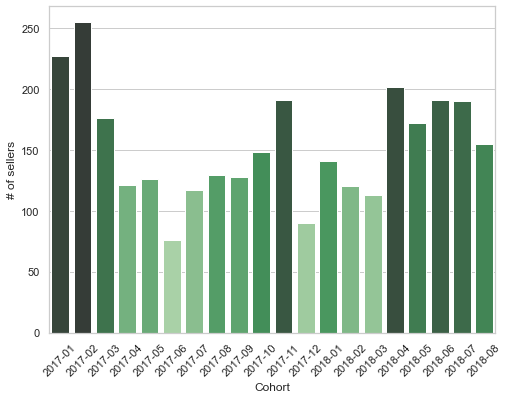

In [6]:
size_cohorts = (cohort_df
                .groupby(['cohort', 'delta'])[['seller_id']]
                .nunique()
                .query('delta == 0')
                .reset_index()
                )

# Plot:

sns.set(style="whitegrid", color_codes=True)
pal = sns.color_palette("Greens_d", len(size_cohorts))
rank = size_cohorts.seller_id.argsort().argsort()
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=size_cohorts, y='seller_id', x='cohort', palette=np.array(pal)[rank])
ax.set(xlabel='Cohort', ylabel='# of sellers')
plt.xticks(rotation=45);

As we can see, there were some variability in the number of new sellers joining Olist in the period under analysis, but nothing really outstanding that invalidate our exercise in this post.


The next step consist in:

- Counting the unique sellers in each delta by each cohort;
- Counting the total sellers in each cohort (the number of sellers in the first month, i.e., when delta is equal to zero)
- Calculating the proportion of sellers present in each cohort afterwards

In [8]:
cohort_df = (cohort_df
             .groupby(['cohort', 'delta'])[['seller_id']]
             .nunique()
             .assign(total = lambda x: x.groupby('cohort')[['seller_id']]
                                        .transform(lambda x: x[0]),
                     proportion = lambda x: 100 * x.seller_id / x.total)
             .reset_index()
             .loc[:, ['cohort', 'delta', 'proportion']]
            )

cohort_df.head(3)

,cohort,delta,proportion
0,2017-01,0,100.000000
1,2017-01,1,75.770925
2,2017-01,2,73.568282


Now we have all the information we need to calculate make the cohort analysis, but it is in the long format. The following step consists in applying a `pivot` method to reshape it:


In [9]:
cohort_pivot = (
    cohort_df[['cohort', 'delta', 'proportion']]
    .pivot(columns='delta', index='cohort')['proportion']
)
cohort_pivot

delta,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
cohort,,,,,,,,,,,,,,,,,,,,
2017-01,100.0,75.770925,73.568282,63.436123,66.079295,62.114537,55.947137,60.792952,55.506608,55.947137,54.625551,48.458150,50.660793,47.577093,48.458150,45.374449,38.766520,38.766520,35.682819,39.207048
2017-02,100.0,61.176471,54.509804,56.470588,45.098039,48.627451,47.450980,42.352941,41.960784,41.568627,41.960784,36.862745,35.686275,35.294118,37.254902,29.411765,30.980392,28.627451,25.882353,NaN
2017-03,100.0,57.954545,54.545455,49.431818,46.022727,48.295455,44.886364,40.909091,48.295455,36.931818,39.772727,32.954545,34.090909,30.681818,29.545455,29.545455,26.136364,27.840909,NaN,NaN
2017-04,100.0,55.371901,47.107438,51.239669,49.586777,44.628099,38.016529,47.107438,39.669421,38.842975,32.231405,33.884298,32.231405,30.578512,25.619835,28.925620,23.140496,NaN,NaN,NaN
2017-05,100.0,50.000000,50.000000,51.587302,46.825397,42.857143,43.650794,37.301587,39.682540,40.476190,35.714286,31.746032,27.777778,23.809524,27.777778,20.634921,NaN,NaN,NaN,NaN
2017-06,100.0,42.105263,40.789474,47.368421,31.578947,38.157895,36.842105,32.894737,27.631579,28.947368,27.631579,26.315789,21.052632,22.368421,21.052632,NaN,NaN,NaN,NaN,NaN
2017-07,100.0,67.521368,60.683761,59.829060,67.521368,59.829060,56.410256,52.991453,52.136752,52.136752,49.572650,49.572650,44.444444,47.863248,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,100.0,54.263566,46.511628,55.038760,42.635659,44.186047,49.612403,42.635659,40.310078,37.984496,37.209302,31.782946,34.883721,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,100.0,53.125000,54.687500,46.875000,50.000000,40.625000,44.531250,40.625000,40.625000,33.593750,31.250000,33.593750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


With the pivoted column, we can simply use the `sns.heatmap` function to visualize the cohorts:

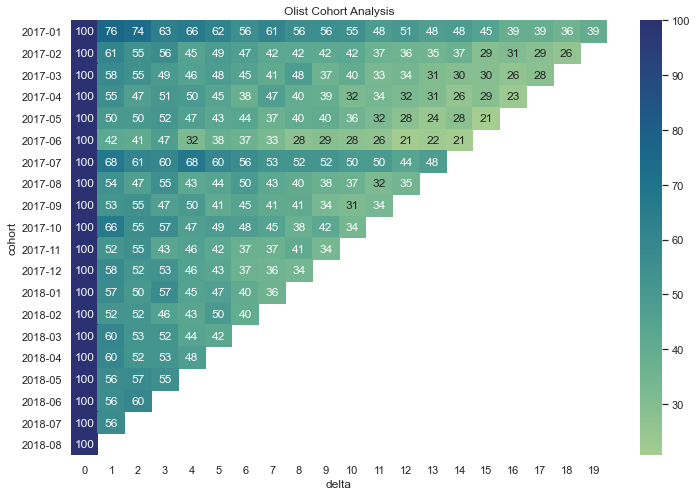

In [10]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    cohort_pivot, 
    cmap='crest', 
    annot=True, 
    fmt='.0f'
).set_title("Olist Cohort Analysis")

It's interesting to note that the first cohort was relatively more loyal to Olist than the cohorts that followed, with a participation rate 6 months after their first sale in the platform that was similar to the participation rate of the other cohorts. It's also noteworthy that the cohort '2017-07' was also loyal to the brand.

Now it is up to the marketing team of Olist to investigate further why some of the cohorts presented churn rates much lower than the others and act upon this information.